In [293]:
import numpy as np
from scipy.integrate import quad, dblquad
import matplotlib.pyplot as plt
from astropy import constants as const
from astropy import units as u
plt.style.use('default')

#### Density

In [294]:
def rho_DM1(x, M=1.25e15, a=600):
    return (M/(2*np.pi*a**3))*(1/((x/a)*(1+x/a)**3))

def rho_DM2(x, M=2.6e14, a=350):  
    return (M/(2*np.pi*a**3))*(1/((x/a)*(1+x/a)**3))

def rho_g1(x, rho_g0=0.472e7, a=600, a_c=60, c=0.17, n=5):
    alpha = -1 - n*(c-1)/(c-a/a_c)
    beta =  1 - n*(1-a/a_c)/(c-a/a_c)
    return rho_g0 * (1+x/a_c) * (1+(x/a_c)/c)**alpha * (1+x/a)**beta

def rho_g2(x, rho_g0=0.98e7, a=350, a_c=60, c=0.17, n=5):
    alpha = -1 - n*(c-1)/(c-a/a_c)
    beta =  1 - n*(1-a/a_c)/(c-a/a_c)
    return rho_g0 * (1+x/a_c) * (1+(x/a_c)/c)**alpha * (1+x/a)**beta

In [295]:
# The radius profile set in 
r  = np.logspace(np.log10(0.25), np.log10(2400), 1000)

In [296]:
dens1 = rho_g1(r)
dens2 = rho_g2(r)
pden1 = rho_DM1(r)
pden2 = rho_DM2(r)
totden2 = dens2 + pden2

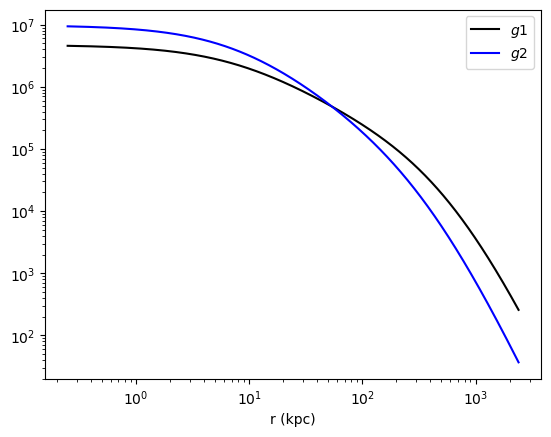

In [297]:
fig, ax = plt.subplots()
ax.set(
    xlabel="r (kpc)",
    # ylabel="${\rho}$(r) ($M_{\odot}$/${kpc^3}$)",
    xscale="log",
    yscale="log",
    # ylim=(1e9, 1.5e15),
)
ax.plot(r, dens1, "-k", label="$g1$")
ax.plot(r, dens2, "-b", label="$g2$")
ax.legend()


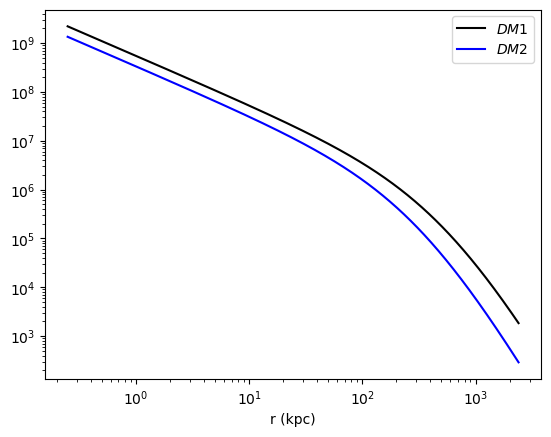

In [298]:
fig, ax = plt.subplots()
ax.set(
    xlabel="r (kpc)",
    # ylabel="${\rho}$(r) ($M_{\odot}$/${kpc^3}$)",
    xscale="log",
    yscale="log",
    # ylim=(1e9, 1.5e15),
)
ax.plot(r, pden1, "-k", label="$DM1$")
ax.plot(r, pden2, "-b", label="$DM2$")
ax.legend()


In [299]:
# Convert to cgs unit
unit = (1*u.solMass/(1*u.kpc**3)).cgs
unit.value

6.767905323247329e-32

In [300]:
pden1 = pden1*unit.value
pden2 = pden2*unit.value
dens1 = dens1*unit.value
dens2 = dens2*unit.value
totden2 = totden2*unit.value

In [309]:
# Save the data in npz file
np.save('dens2.npy', dens2)
np.save('pden2.npy', pden2)
np.save('totden2.npy', totden2)

#### Mass

In [302]:
def dM_DM1(x):
    return 4*np.pi*x**2*rho_DM1(x)

def dM_DM2(x):
    return 4*np.pi*x**2*rho_DM2(x)

def dM_g1(x):
    return 4*np.pi*x**2*rho_g1(x)

def dM_g2(x):
    return 4*np.pi*x**2*rho_g2(x)

In [303]:
def M_DM1(x):
    return quad(dM_DM1, 0, x)

def M_DM2(x):
    return quad(dM_DM2, 0, x)

def M_g1(x):
    return quad(dM_g1, 0, x)

def M_g2(x):
    return quad(dM_g2, 0, x)


In [304]:
# Subcluster gas/DM mass ratio within viral radius Rvir=1.5Mpc
M_g2(2400)[0]/M_DM2(2400)[0]

0.12178560610567936

In [305]:
vec_M_DM1 = np.vectorize(M_DM1)
vec_M_DM2 = np.vectorize(M_DM2)
vec_M_g1 = np.vectorize(M_g1)
vec_M_g2 = np.vectorize(M_g2)


In [306]:
M_DM1_r = vec_M_DM1(r)[0]
M_DM2_r = vec_M_DM2(r)[0]
M_g1_r = vec_M_g1(r)[0]
M_g2_r = vec_M_g2(r)[0]
M1_r = M_DM1_r + M_g1_r
M2_r = M_DM2_r + M_g2_r

In [307]:
# Total mass of sub-cluster (should be 1/5 of main cluster)
M2_r[-1]

222146925448445.0

In [308]:
# Total gas mass of sub-cluster
M_g2_r[-1]

24117173382329.312

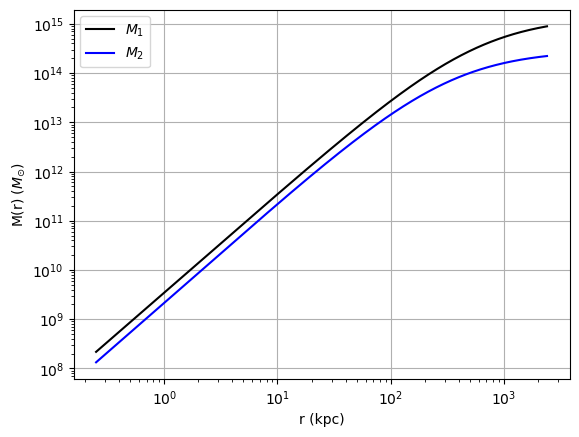

In [279]:
fig, ax = plt.subplots()
ax.set(
    xlabel="r (kpc)",
    ylabel="M(r) ($M_{\odot}$)",
    xscale="log",
    yscale="log",
    # ylim=(1e9, 1.5e15),
)
ax.plot(r, M1_r, "-k", label="$M_{1}$")
ax.plot(r, M2_r, "-b", label="$M_{2}$")
ax.grid()
ax.legend()


In [280]:
# Unit conversion
unit = (1*u.solMass).cgs
mtot2 = M2_r*unit.value
mDM2  = M_DM2_r*unit.value

In [281]:
# Save the result
np.save('mtot2.npy', mtot2)
np.save('mDM2.npy', mDM2)


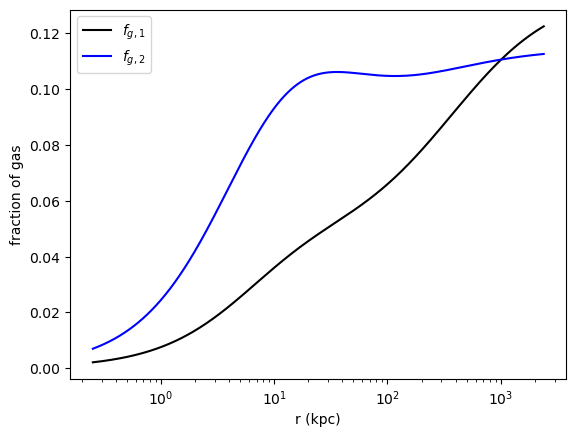

In [282]:
fig, ax = plt.subplots()
ax.set(
    xlabel="r (kpc)",
    ylabel="fraction of gas",
    xscale="log",
    # xlim=(5e0, 5e3),
)
ax.plot(r, rho_g1(r)/(rho_DM1(r)+rho_g1(r)), "-k", label="$f_{g,1}$")
ax.plot(r, rho_g2(r)/(rho_DM2(r)+rho_g2(r)), "-b", label="$f_{g,2}$")
ax.legend()

#### Pressure

In [242]:
def dP1(s, x):
    return -(rho_g1(x)/x**2) * (s**2 * (rho_g1(s)+rho_DM1(s)))

def dP2(s, x):
    return -(rho_g2(x)/x**2) * (s**2 * (rho_g2(s)+rho_DM2(s)))

In [283]:

def P1(r, r_inf=np.Infinity): 
    # without 4 * pi * G and in unit of [kpc] [solar_mass]
    P1_var = dblquad(lambda s, x: dP1(s, x), r_inf, r, lambda s: 0, lambda s: s)[0]
    return (4*np.pi*const.G * P1_var * u.solMass**2 * u.kiloparsec**(-4)).cgs


def P2(r, r_inf=np.Infinity): 
    # without 4 * pi * G and in unit of [kpc] [solar_mass]
    P1_var = dblquad(lambda s, x: dP2(s, x), r_inf, r, lambda s: 0, lambda s: s)[0]
    return (4*np.pi*const.G * P1_var * u.solMass**2 * u.kiloparsec**(-4)).cgs



In [284]:
(const.G * u.solMass**2 * u.kiloparsec**(-4)).cgs

<Quantity 2.91082009e-27 P / s>

In [285]:
# P1_r = np.array([P1(i).value for i in r])
P2_r = np.array([P2(i).value for i in r])

/cluster/home/yhgong/.conda/envs/ytplot/lib/python3.6/site-packages/scipy/integrate/quadpack.py:881: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  **opt)


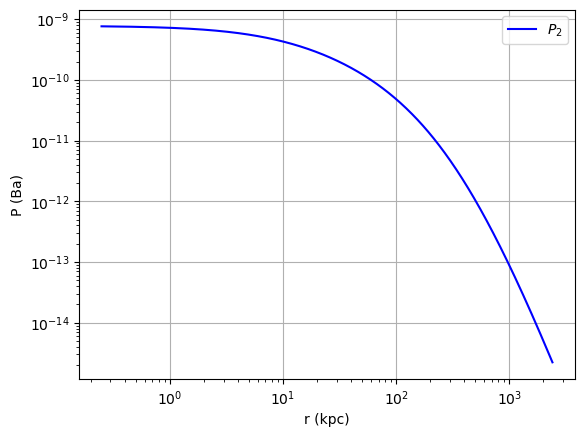

In [286]:
fig, ax = plt.subplots()
ax.set(
    xlabel="r (kpc)",
    ylabel="P (Ba)",
    xscale="log",
    yscale="log"
)
# ax.plot(r, P1_r, "-k", label="$P_{1}$")
ax.plot(r, P2_r, "-b", label="$P_{2}$")
ax.grid()
ax.legend()

In [287]:
# Save the result
pres2 = P2_r
np.save('pres2.npy', pres2)

#### Gravational Field

In [288]:
grav2 = ((-const.G* M2_r*u.solMass / (r*u.kpc)**2).cgs).value
np.save('grav2.npy', grav2)

#### Gravational Potential

In [289]:
def dPotential_2(s, x):
    return (1/x**2) * (s**2 * (rho_g2(s)+rho_DM2(s)))

def Potential_2(r, r_inf=np.Infinity): 
    # without 4 * pi * G and in unit of [kpc] [solar_mass]
    var = dblquad(lambda s, x: dPotential_2(s, x), r_inf, r, lambda s: 0, lambda s: s)[0]
    return (4*np.pi*const.G * var * u.solMass * u.kiloparsec**(-1)).cgs

In [290]:
Potential_2(100)

<Quantity -2.78146438e+16 cm2 / s2>

In [291]:
gpot2 = np.array([Potential_2(i).value for i in r])

In [257]:
np.save('gpot2.npy', gpot2)

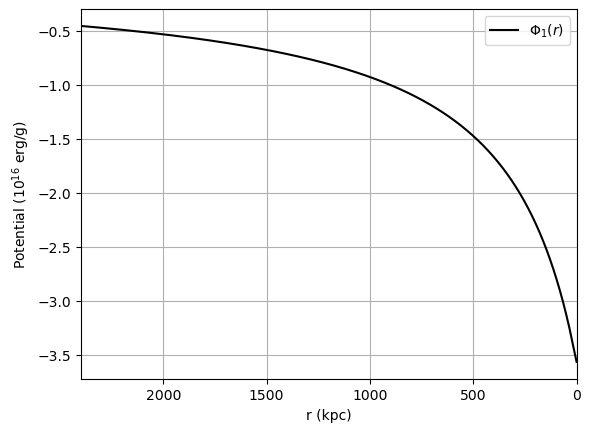

In [292]:
fig, ax = plt.subplots()
ax.set(
    xlabel="r (kpc)",
    ylabel="Potential ($10^{16}$ erg/g)",
    xlim=(2400, 0),
)
ax.plot(r, gpot2/1e16, "-k", label="$\Phi_{1}(r)$")
ax.legend()
ax.grid()